In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle


In [2]:
# you need to upload kaggle.json file from your kaggle account
from google.colab import files
files.upload()  # Kaggle.json file is present under api keys in your profile

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content
!unzip -q /content/cell-images-for-detecting-malaria.zip -d /content/


Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 97% 653M/675M [00:01<00:00, 282MB/s]
100% 675M/675M [00:02<00:00, 344MB/s]


In [4]:
import os
print(os.listdir('/content/cell_images'))
print(len(os.listdir('/content/cell_images/Parasitized')))
print(len(os.listdir('/content/cell_images/Uninfected')))


['cell_images', 'Uninfected', 'Parasitized']
13780
13780


In [5]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

def extract_img(path, categories):
    """
    Extracts and preprocesses images from folders named after class labels.

    Args:
        path (str): Root path containing category folders.
        categories (list): List of category folder names.

    Returns:
        data (list): List of (image_array, label) tuples.
    """
    data = []

    for label, category in enumerate(categories):
        folder_path = os.path.join(path, category)
        print(f"Loading category '{category}'...")

        for filename in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize((64, 64))  # Fixed image size
                img_array = np.array(img)
                data.append((img_array, label))
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
                continue

    return data


In [6]:
categories = ["Parasitized", "Uninfected"]
data_path = "/content/cell_images"
data = extract_img(data_path, categories)


Loading category 'Parasitized'...


 40%|████      | 5546/13780 [00:06<00:16, 488.15it/s]

Skipping /content/cell_images/Parasitized/Thumbs.db: cannot identify image file '/content/cell_images/Parasitized/Thumbs.db'


100%|██████████| 13780/13780 [00:14<00:00, 970.53it/s] 


Loading category 'Uninfected'...


 40%|████      | 5576/13780 [00:05<00:07, 1106.03it/s]

Skipping /content/cell_images/Uninfected/Thumbs.db: cannot identify image file '/content/cell_images/Uninfected/Thumbs.db'


100%|██████████| 13780/13780 [00:13<00:00, 1044.51it/s]


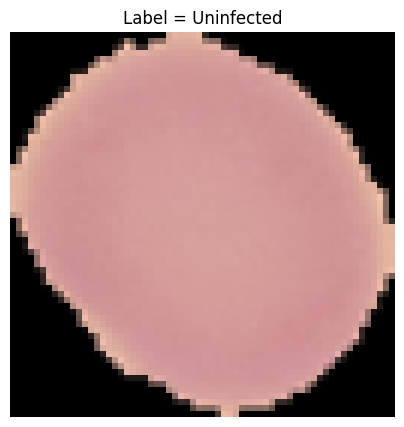

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Optional: define labels
labels = {0: "Parasitized", 1: "Uninfected"}

# Shuffle and select a random sample
random.seed(42)
random.shuffle(data)
random_index = np.random.randint(0, len(data))  # corrected range

# Plot
plt.figure(figsize=(5, 5))  # note: use plt.figure (capital F not needed)
plt.imshow(data[random_index][0])
plt.title(f'Label = {labels[data[random_index][1]]}')
plt.axis('off')
plt.show()


In [8]:
print("Total Images:",len(data))

Total Images: 27558


In [9]:
x=[]
y=[]
for img,label_ in data:
    x.append(img)
    y.append(label_)

x=np.array(x).astype('float32')/255.0
y=np.array(y)

np.set_printoptions(precision=10,suppress=False)
print(x[10].max())

0.8392157


In [10]:
# Train test split
from sklearn.model_selection import train_test_split

In [11]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
print("x train shape:", xtrain.shape)
print("y train shape:", ytrain.shape)
print("x test shape:", xtest.shape)
print("y test shape:", ytest.shape)

x train shape: (22046, 64, 64, 3)
y train shape: (22046,)
x test shape: (5512, 64, 64, 3)
y test shape: (5512,)


In [12]:
import tensorflow as tf

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten

In [14]:
model=Sequential()
model.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu',input_shape=(64,64,3)))
model.add(Dropout(0.2))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu'))
model.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu'))
model.add(Flatten())
model.add(Dense(200,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 150)    │         7,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 61, 61, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 150)    │       360,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 150)    │       360,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 150)      │       360,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12150)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │     2,430,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,518,201 (13.42 MB)

 Trainable params: 3,518,201 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [17]:
model_history=model.fit(xtrain,ytrain,
                        validation_split=0.33,
                        batch_size=100,
                        epochs=1000,
                        callbacks=[early_stop]
                        )

Epoch 1/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.5020 - loss: 0.7450 - val_accuracy: 0.5197 - val_loss: 0.6902
Epoch 2/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.5393 - loss: 0.6867 - val_accuracy: 0.5667 - val_loss: 0.6417
Epoch 3/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.7642 - loss: 0.4431 - val_accuracy: 0.9206 - val_loss: 0.2789
Epoch 4/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9221 - loss: 0.2130 - val_accuracy: 0.9404 - val_loss: 0.1665
Epoch 5/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.9449 - loss: 0.1704 - val_accuracy: 0.9515 - val_loss: 0.1458
Epoch 6/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9497 - loss: 0.1610 - val_accuracy: 0.9556 - val_loss: 0.1312
Epoch 7/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9585 - loss: 0.1290 - val_accuracy: 0.9530 - val_loss: 0.1400
Epoch 8/1000
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9616 

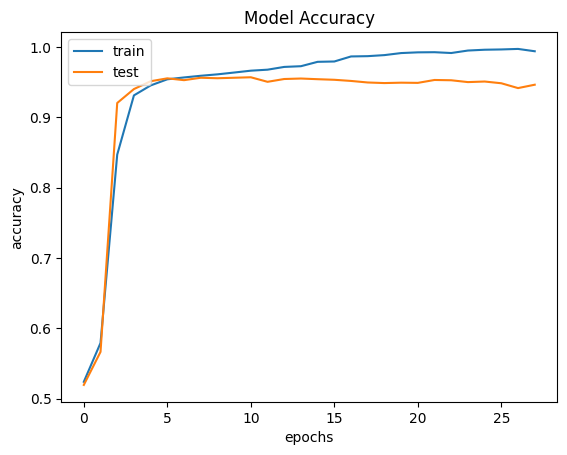

In [18]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

* here we can see our model is performing well in training but not performing well in testing.
* so our model is over fitting

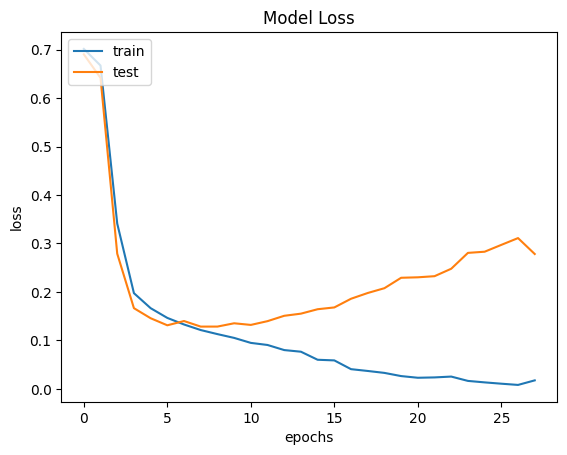

In [19]:
# Plotting the loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [20]:
# prediction
ypred=model.predict(xtest)
ypred=(ypred>0.5)

173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [22]:
print(f"accuracy:{accuracy_score(ytest,ypred)}")
print(f'confusion matrix:\n {confusion_matrix(ytest,ypred)}')
print(f"classification report:\n {classification_report(ytest,ypred)}")

accuracy:0.9499274310595065
confusion matrix:
 [[2642  103]
 [ 173 2594]]
classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      2745
           1       0.96      0.94      0.95      2767

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



In [37]:
import seaborn as sns

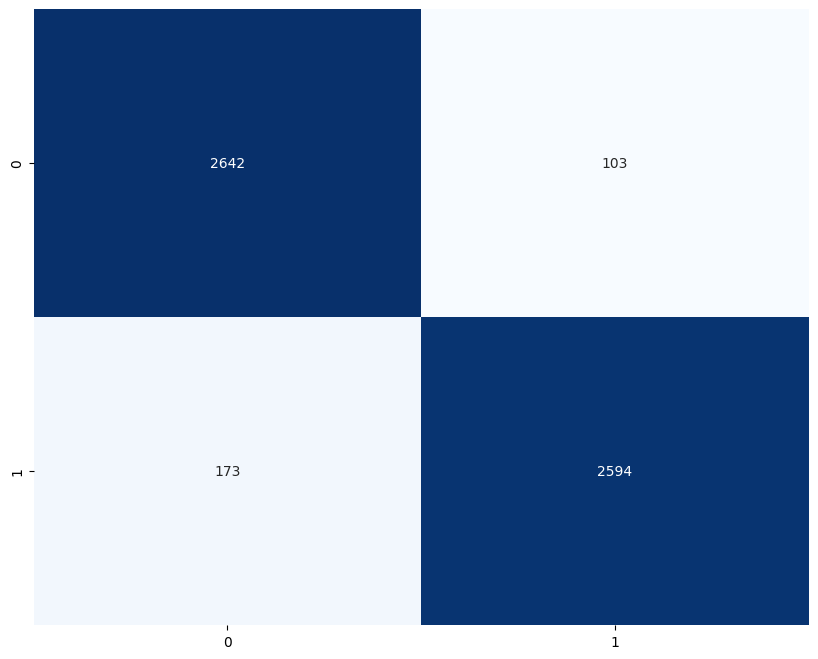

In [43]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(ytest,ypred),annot=True,cbar=False,cmap='Blues',fmt='g')
plt.show()

- lets perform some fine tuning
- Starting from monitoring validation loss
- reduce patience
- increase the drop out

In [30]:
model1=Sequential()
model1.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu',input_shape=(64,64,3)))
model1.add(Dropout(0.4))
model1.add(tf.keras.layers.MaxPooling2D(2,2))
model1.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu'))
model1.add(Dropout(0.4))
model1.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(2,2))
model1.add(tf.keras.layers.Conv2D(150,(4,4),activation='relu'))
model1.add(Flatten())
model1.add(Dense(200,activation='relu'))
# model1.add(Dropout(0.5))
model1.add(Dense(1,activation='sigmoid'))

In [31]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 61, 61, 150)    │         7,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 61, 61, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 27, 27, 150)    │       360,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 27, 27, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 150)    │       360,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 9, 9, 150)      │       360,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12150)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │     2,430,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,518,201 (13.42 MB)

 Trainable params: 3,518,201 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=9,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [33]:
model_history1=model1.fit(xtrain,ytrain,
                        validation_split=0.2,
                        batch_size=100,
                        epochs=1000,
                        shuffle=True,
                        callbacks=[early_stop]
                        )

Epoch 1/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.5136 - loss: 0.7792 - val_accuracy: 0.4950 - val_loss: 0.6916
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - accuracy: 0.5288 - loss: 0.6898 - val_accuracy: 0.4950 - val_loss: 0.7023
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.5543 - loss: 0.6780 - val_accuracy: 0.4950 - val_loss: 0.6797
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6893 - loss: 0.5419 - val_accuracy: 0.9234 - val_loss: 0.2211
Epoch 5/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9408 - loss: 0.1861 - val_accuracy: 0.9395 - val_loss: 0.1708
Epoch 6/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.9519 - loss: 0.1463 - val_accuracy: 0.9485 - val_loss: 0.1537
Epoch 7/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9546 - loss: 0.1374 - val_accuracy: 0.9537 - val_loss: 0.1399
Epoch 8/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9554 

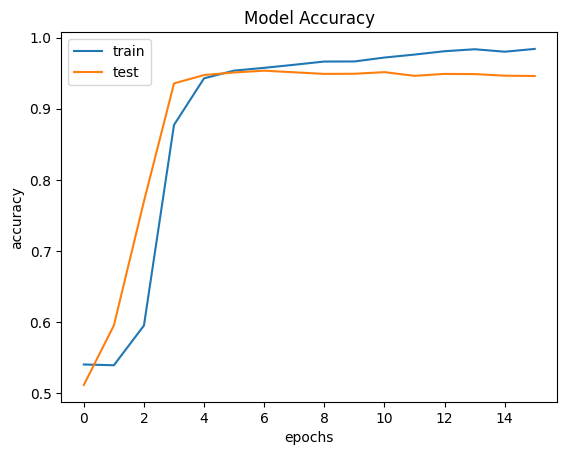

In [27]:
plt.plot(model_history1.history['accuracy'])
plt.plot(model_history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')
plt.show()

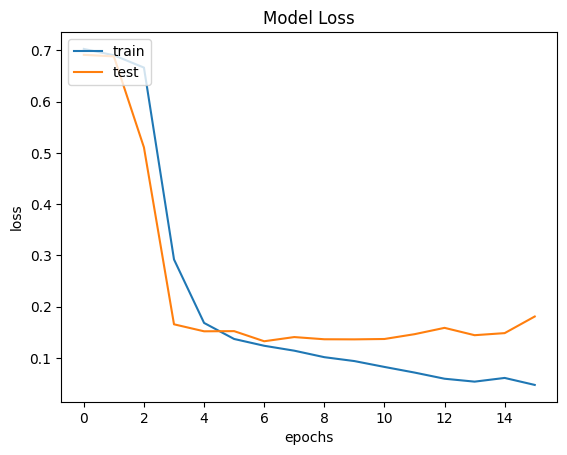

In [28]:
# Plotting the loss
plt.plot(model_history1.history['loss'])
plt.plot(model_history1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [34]:
ypred1=model1.predict(xtest)

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [52]:
ypred1=(ypred1>0.5)

In [53]:
ypred1

array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [36]:
print(f"accuracy:{accuracy_score(ytest,ypred1)}")
print(f'confusion matrix:\n {confusion_matrix(ytest,ypred1)}')
print(f"classification report:\n {classification_report(ytest,ypred1)}")

accuracy:0.9631712626995645
confusion matrix:
 [[2601  144]
 [  59 2708]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      2745
           1       0.95      0.98      0.96      2767

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



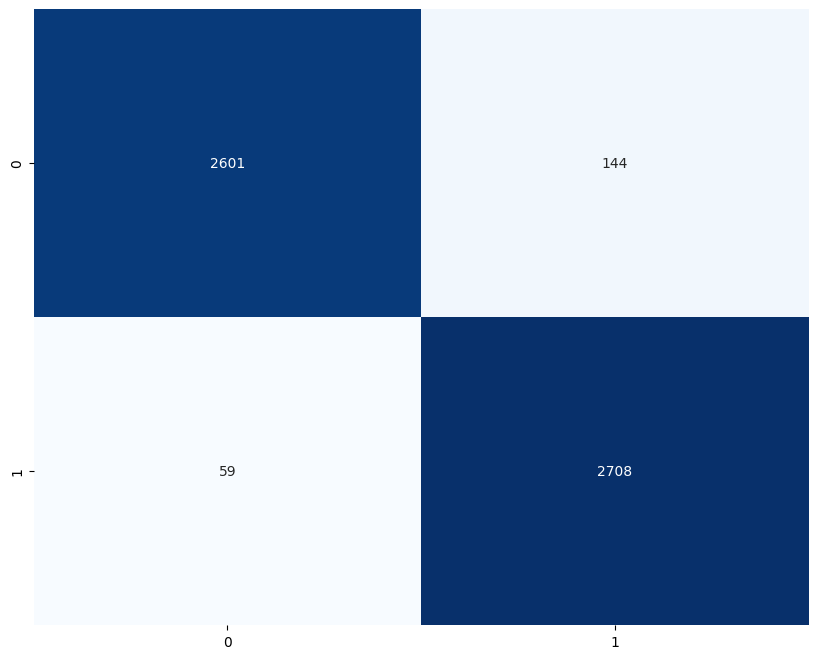

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(ytest,ypred1),annot=True,cbar=False,cmap='Blues',fmt='g')
plt.show()

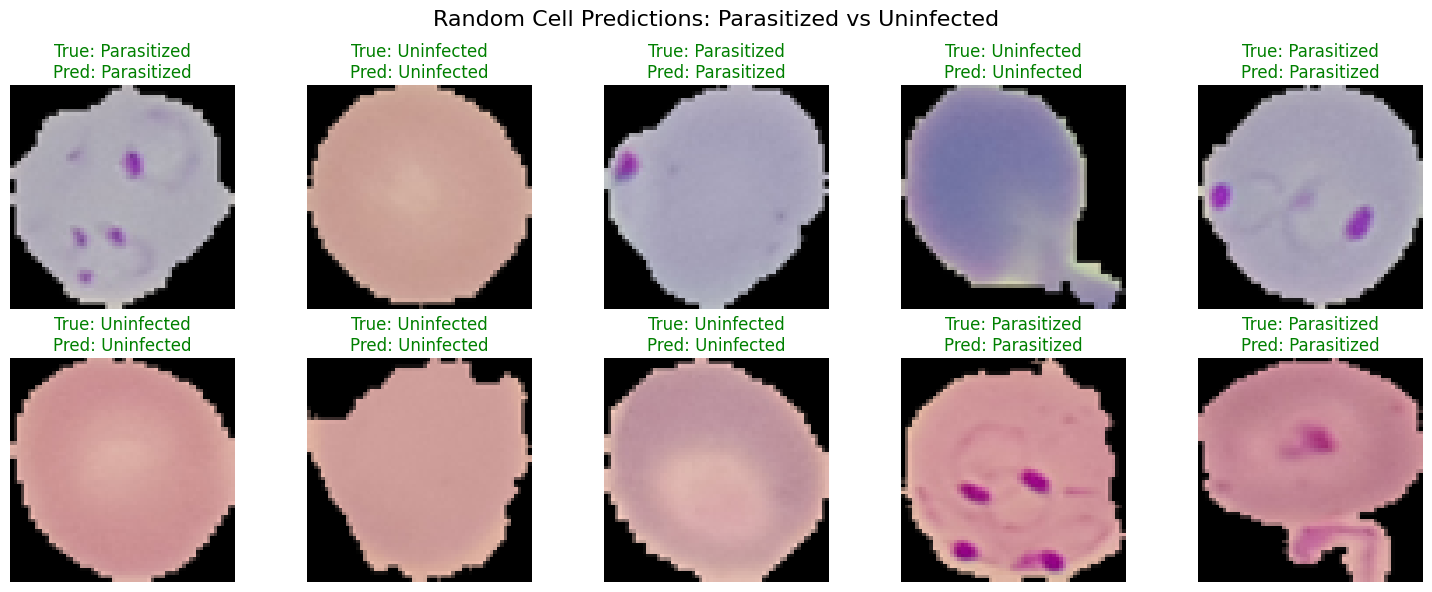

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Converting boolean predictions to class labels (0 or 1)
y_pred_classes = ypred1.astype(int).reshape(-1)
y_true = ytest.reshape(-1)

# label mapping to label whether the cells are parasitized or not
label_map = {0: 'Parasitized', 1: 'Uninfected'}

# Selecting 10 random test indices
random_indices = random.sample(range(len(xtest)), 10)

# Plottting
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(xtest[idx])
    plt.axis('off')

    true_label = label_map[y_true[idx]]
    pred_label = label_map[y_pred_classes[idx]]
    color = 'green' if true_label == pred_label else 'red'

    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.suptitle("Random Cell Predictions: Parasitized vs Uninfected", fontsize=16)
plt.tight_layout()
plt.show()


In [5]:
# saving the model1
# model1.save("malaria_cell_pred_cnn.h5")

In [6]:
# from tensorflow.keras.models import load_model

In [7]:
# model=load_model('malaria_cell_pred_cnn.h5')